# DSSATTools Tutorial

In this notebook you'll see the basic usage of DSSATools library to:
1. Create the inputs
2. Initialize the simulation environment
3. Run simulations
4. Modify input objects
5. Read outputs.

In this notebook you'll be guided through the most important features of the library. If you're familiar to DSSAT, then most of the concepts here introduced won't be new. If you're new to DSSAT then I strongly recommend you to go over the desktop app and its basic documentation.

In [1]:
from DSSATTools import (
    Crop, SoilProfile, Weather, Management, DSSAT, SoilLayer,
    available_cultivars
)
import DSSATTools
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

### Create a WeatherData instance

To perform a simulation we need to provide for different elements: Weather, Crop, Soil and Managment. All those elements play an important role in the soil-plant-atmosphere system. This library provides four classes to define those four elements. The first element to be defined in this tutorial is the weather. The `Weather` class provides an interface to define the weather data that will be used by DSSAT. Regardless of the data source (surface stations, weather generators, reanalysis models, etc.) you must provide the data as a pandas DataFrame, the details of the station (Longitude, latitude, elevation) and a dict mapping each DataFrame column to a required DSSAT weather Variable. 

To check the weather variables that can be passed to DSSAT use the next function:

In [2]:
DSSATTools.weather.list_weather_variables()

DATE: Date, year + days from Jan. 1
SRAD: Daily solar radiation, MJ m-2 day-1
TMAX: Daily temperature maximum, C
TMIN: Daily temperature minimum, C
RAIN: Daily rainfall (incl. snow), mm day-1
DEWP: Daily dewpoint temperature average, C
WIND: Daily wind speed (km d-1)
PAR: Daily photosynthetic radiation, moles m-2 day-1
EVAP: Daily pan evaporation (mm d-1)
RHUM: Relative humidity average, %


Not all variables are required. The variables that you use depend on your data availability and the methods used to simulate the different processes in the crop (i.e. Evapotranspiration).

For this tutorial we'll initialize our `Weather` instance using fake weather data.

In [3]:
# Random weather data
DATES = pd.date_range('2008-01-01', '2010-12-31')
N = len(DATES)
df = pd.DataFrame(
    {
    'tn': np.random.gamma(10, 1, N),
    'rad': np.random.gamma(10, 1.5, N),
    'prec': [0.0]* N,
    'rh': 100 * np.random.beta(1.5, 1.15, N),
    },
    index=DATES,
)
df['TMAX'] = df.tn + np.random.gamma(5., .5, N)
df.head()

,tn,rad,prec,rh,TMAX
2008-01-01,8.043462,13.824409,0.0,10.897689,11.098390
2008-01-02,11.579064,6.707478,0.0,93.257426,14.335268
2008-01-03,9.767416,20.162002,0.0,58.279148,12.737142
2008-01-04,15.988123,12.384802,0.0,15.851498,17.161463
2008-01-05,7.269379,20.161662,0.0,80.534821,10.822562


In [4]:
# Create a WheaterStation instance
wth = Weather(
    df, 
    {'tn': 'TMIN', 'TMAX': 'TMAX', 'prec': 'RAIN', 
     'rad': 'SRAD', 'rh': 'RHUM'}, 
    4.3434237,-74.3606715, 1800
)
wth

Weather data at -74.361°, 4.343°
  Date start: 2008-01-01
  Date end: 2010-12-31
Average values:
TMAX    12.506634
TMIN    10.021835
RAIN     0.000000
SRAD    15.019526
RHUM    57.011968
dtype: float64

Note that for all the four basic classes, and the `Section` class have an implementation of the `__repr__` method. It means that you can display the variable in a human-readable form. The idea is to display the basic details of each element, as you can see with the `wth` object we just created.

## Create a SoilProfile 

You can use a default soil profile, or you can create your own soil profile. To check the available soil profiles you can use the `help` function to check the docstring of the `SoilProfile` class:

In [5]:
help(SoilProfile)

Help on class SoilProfile in module DSSATTools.soil:

class SoilProfile(builtins.object)
 |  SoilProfile(file: str = None, profile: str = None, default_class: str = None, pars: dict = {})
 |  
 |  Methods defined here:
 |  
 |  __init__(self, file: str = None, profile: str = None, default_class: str = None, pars: dict = {})
 |      Soil Profile class. It can be initialized from an existing file. It also 
 |      can be initialized from scratch.  If a file is provided, then the soil is
 |      initialized as the soil profile with the matching profile id in the file.
 |      
 |      Arguments
 |      ----------
 |      file: str
 |          Optional. Path to the soil file.
 |      profile: str
 |          Optional. Must be passed if file argument is passed. It's the id of 
 |          the profile within the file.
 |      pars: dict
 |          Dict with the non-layer soil parameters. 
 |      default_class: str
 |          Optional. It's a string defining a DSSAT default soil class. If 

So, we'll define a Loamy soil:

In [6]:
# Soil instance from default soil profile
soil = SoilProfile(default_class='L')
soil

*IUBF970211  SOREN-  IA  L       210 Ritchie 6/12/97  Loam
@SITE        COUNTRY          LAT     LONG SCS FAMILY
 -99         -99             2.000   -0.099 unknown                             
@ SCOM  SALB  SLU1  SLDR  SLRO  SLNF  SLPF  SMHB  SMPX  SMKE
   -99  0.09   7.0  0.55  60.0  0.50  0.92 IB001 IB001 IB001
@  SLB  SLMH  SLLL  SDUL  SSAT  SRGF  SSKS  SBDM  SLOC  SLCL  SLSI  SLCF  SLNI  SLHW  SLHB  SCEC  SADC
     5   -99 0.163 0.340 0.465 1.000 79.00  1.31  2.03  26.0  36.0   -99   -99   6.4   -99   -99   -99
    15   -99 0.163 0.340 0.438 1.000 79.00  1.39  2.03  26.0  36.0   -99   -99   6.4   -99   -99   -99
    30   -99 0.173 0.350 0.451 1.000 79.00  1.35  2.03  27.0  37.0   -99   -99   6.4   -99   -99   -99
    45   -99 0.193 0.350 0.458 1.000 79.00  1.33  2.03  27.0  37.0   -99   -99   6.4   -99   -99   -99
    60   -99 0.193 0.350 0.451 1.000 79.00  1.35  0.44  27.0  37.0   -99   -99   6.7   -99   -99   -99
    75   -99 0.173 0.350 0.458 1.000 79.00  1.33  0.44  29.0  36.0

That's the easy way of definig your soil. However, if you have enough data you can define your soil. A `SoilProfile` object is a series of stacked `SoilLayer` objects. Each layer can have different properties, and you can define them separately. You define your custom soil profile in two steps:

1. Initialize the instance. A dictionary with the profile properties have to be defined. 
2. Create the soil layers that will conform that SoilProfile. You need to indicate the depth and properties of that layer.
3. Add the layers to the soil.

For each layer you can define the as many parameters as you want. However, if you only have the soil texture, the rest of the parameters will be calculated from the texture. That's what we'll do next:

In [7]:
soilprofile = SoilProfile(
    pars={
        'SALB': 0.25, # Albedo
        'SLU1': 6, # Stage 1 Evaporation (mm)
        'SLPF': 0.8 # Soil fertility factor
    }
)
layers = [
    SoilLayer(20, {'SLCL': 50, 'SLSI': 45}),
    SoilLayer(50, {'SLCL': 30, 'SLSI': 30}),
    SoilLayer(80, {'SLCL': 32, 'SLSI': 31}),
    SoilLayer(110, {'SLCL': 30, 'SLSI': 35}),
    SoilLayer(140, {'SLCL': 24, 'SLSI': 33}),
    SoilLayer(170, {'SLCL': 20, 'SLSI': 30})
]
for layer in layers: soilprofile.add_layer(layer)
soilprofile

*IB12345678  Soil profile
@SITE        COUNTRY          LAT     LONG SCS FAMILY
   Huntsville      AL-USA   34.725  -86.645                               Custom
@ SCOM  SALB  SLU1  SLDR  SLRO  SLNF  SLPF  SMHB  SMPX  SMKE
   -99  0.25   6.0  0.50  60.0  1.00  0.80 IB001 IB001 IB001
@  SLB  SLMH  SLLL  SDUL  SSAT  SRGF  SSKS  SBDM  SLOC  SLCL  SLSI  SLCF  SLNI  SLHW  SLHB  SCEC  SADC
    20   -99 0.305 0.486 0.514 1.000  0.72  1.42  0.80  50.0  45.0   -99   -99   -99   -99   -99   -99
    50   -99 0.224 0.387 0.415 0.497  0.24  1.38  0.80  30.0  30.0   -99   -99   -99   -99   -99   -99
    80   -99 0.232 0.396 0.423 0.273  0.23  1.39  0.80  32.0  31.0   -99   -99   -99   -99   -99   -99
   110   -99 0.227 0.401 0.425 0.150  0.28  1.39  0.80  30.0  35.0   -99   -99   -99   -99   -99   -99
   140   -99 0.207 0.377 0.403 0.082  0.33  1.38  0.80  24.0  33.0   -99   -99   -99   -99   -99   -99
   170   -99 0.193 0.359 0.390 0.045  0.56  1.37  0.80  20.0  30.0   -99   -99   -99   -99   -99   

## Create a Crop object from default crop file

The crop is the easiest part. You just have to indicate the crop name, and the cultivar. If you don't know what cultivars are available you can use the `available_cultivars` function:

In [8]:
available_cultivars("maize")

['999991',
 '999992',
 'PC0001',
 'PC0002',
 'PC0003',
 'PC0004',
 'PC0005',
 '990001',
 '990002',
 '990003',
 '990004',
 'IB0001',
 'IB0002',
 'IB0003',
 'IB0004',
 'IB0005',
 'IB0006',
 'IB0007',
 'IB0008',
 'IB0009',
 'IB0010',
 'IB0011',
 'IB0012',
 'IB0013',
 'IB0014',
 'IB0015',
 'IB0016',
 'IB0017',
 'IB0018',
 'IB0019',
 'IB0020',
 'IB0021',
 'IB0022',
 'IB0023',
 'IB0024',
 'IB0025',
 'IB0026',
 'IB0027',
 'IB0028',
 'IB0029',
 'IB0030',
 'IB0031',
 'IB0032',
 'IB0033',
 'IB0034',
 'IB0035',
 'IB0036',
 'IB0037',
 'IB0038',
 'IB0039',
 'IB0040',
 'IB0041',
 'IB0042',
 'IB0043',
 'IB0044',
 'IB0045',
 'IB0046',
 'IB0047',
 'IB0048',
 'IB0049',
 'IB0050',
 'IB0051',
 'IB0052',
 'IB0053',
 'IB0054',
 'IB0055',
 'IB0056',
 'IB0057',
 'IB0058',
 'IB0059',
 'IB0060',
 'IB0061',
 'IB0062',
 'IB0063',
 'IB0064',
 'IB0065',
 'IB0066',
 'IB0067',
 'IB0068',
 'IB0168',
 'IB0069',
 'IB0070',
 'IB0071',
 'IB0089',
 'IB0090',
 'IB0091',
 'IB0092',
 'IB0093',
 'IB0099',
 'IB0100',
 'IB1051',

In [9]:
crop = Crop("maize", 'IB0001')

The crop parameters can be accessed and modified in two attributes: cultivar and ecotype. Those attributes are defined as a `Section` class. You can check the parameters hosted by that section by printing the object:

In [10]:
crop.cultivar

Cultivar section
  Maize crop
  Parameters:
    @VAR#: IB0001
    VRNAME..........: CORNL281        
    EXPNO:     .
    ECO#: IB0001
    P1: 110.0
    P2: 0.3
    P5: 685.0
    G2: 907.9
    G3: 6.6
    PHINT: 38.9

Of course, you can modify the parameters using the usual key, value notation:

In [11]:
crop.cultivar["P1"] = 105.
crop.cultivar

Cultivar section
  Maize crop
  Parameters:
    @VAR#: IB0001
    VRNAME..........: CORNL281        
    EXPNO:     .
    ECO#: IB0001
    P1: 105.0
    P2: 0.3
    P5: 685.0
    G2: 907.9
    G3: 6.6
    PHINT: 38.9

Now if you check the ecotype section you can see that the value changed. Of course you can only read and modify the existing parameters in the section, you can't add new parameters, and some parameters can't be modified.

## Create a management instance

The `Management` parameters are defined in the same way as the `Crop` parameters. Different sections are defined in `Section` objects that are attributes of the `Management` object. The parameters can be modified the same way. When initializing the Managament instance the only mandatory parameter is the planting date. You can check all the options using `help`:

In [12]:
help(Management)

Help on class Management in module DSSATTools.management:

class Management(builtins.object)
 |  Management(planting_date: datetime.datetime, sim_start: datetime.datetime = None, emergence_date: datetime.datetime = None, initial_swc: float = 0.5, irrigation='N', fertilization='N', harvest='M', organic_matter='G')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, planting_date: datetime.datetime, sim_start: datetime.datetime = None, emergence_date: datetime.datetime = None, initial_swc: float = 0.5, irrigation='N', fertilization='N', harvest='M', organic_matter='G')
 |      Initializes a management instance.
 |      
 |      Arguments
 |      ----------
 |      planting_date: datetime
 |          Planting date.
 |      sim_start: datetime
 |          Date for start of the simulation. If None, it'll be calculated as the
 |          previous day to the planting date.
 |      emergence_date: datetime
 |          Emergence date. If None, I'll be calculated as 5 days after planting.
 | 

In [13]:
man = Management(
    planting_date=DATES[10],
)
# Modify irrigation to non-irrigated
man.simulation_controls['IRRIG'] = "N"

Some of the options are automatically defined when the simulation is running. The cultivar and field options is one example. Again, you can see the details of the different section:

In [14]:
# Check the planting details section
man.planting_details

Planting Details section
  Parameters:
    PDATE: 08011
    EDATE: 08016
    PPOP: 16
    PPOE: 15
    PLME: S
    PLDS: R
    PLRS: 35
    PLRD: None
    PLDP: 4
    PLWT: None
    PAGE: None
    PENV: None
    PLPH: None
    SPRL: None
    PLNAME: None

You can also see the description of each parameter in all of the management sections. For example:

In [16]:
man.planting_details.description

PDATE:	Planting date, year + days from Jan. 1
EDATE:	Emergence date, earliest treatment
PPOP:	Plant population at seeding, m-2
PPOE:	Plant population at emergence, m-2
PLME:	Planting method, code
PLDS:	Planting distribution, row R, broadcast B, hill H
PLRS:	Row spacing, cm
PLRD:	Row direction, degrees from N
PLDP:	Planting depth, cm
PLWT:	Planting material dry weight, kg ha-1
PAGE:	Transplant age, days
PENV:	Transplant environment, oC
PLPH:	Plants per hill (if appropriate)


## Setup the simulation environment and run the model

Finally, the `DSSAT` class initialize the so called "Simulation environment". It is simply a class that manages folders, files and parameters to run the simulation. When you call the `DSSAT.setup()` method, a temporary directory will be created and all the files that are required to run the model are copied into that folder. When you the `DSSAT.run()` method you need to pass the soil, crop, weather and management objects as arguments. When you do so, all the input files are created, the model is run, and the PlantGro.OUT file is loaded in the `DSSAT.output` attribute.

In [15]:
dssat = DSSAT()
dssat.setup()
dssat.run(
    soil=soil, weather=wth, crop=crop, management=man,
)

/tmp/dssatsonexzob created.
Static files copied to /tmp/dssatsonexzob.
  Crop failure growth program terminated 
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 MZ   1 -99 122   326     0     0     0    51   129     0   -99      0  176


In [16]:
# Save the output
output_1 = dssat.output['PlantGro']
output_1.head()

,@YEAR,DOY,DAS,DAP,L#SD,GSTD,LAID,LWAD,SWAD,GWAD,...,RL7D,RL8D,RL9D,RL10D,CDAD,LDAD,SDAD,SNW0C,SNW1C,DTTD
2008-01-11,2008,011,2,0,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0.00
2008-01-12,2008,012,3,1,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,6.89
2008-01-13,2008,013,4,2,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1.61
2008-01-14,2008,014,5,3,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,4.31
2008-01-15,2008,015,6,4,0.0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1.19


You can see that the model ran and the output was created. Now let's do something else. If you remember, we set the irrigation management parameter as non-irrigated. Now we can set it to irrigated when needed and compare.

In [17]:
# Modify management and run again
man.simulation_controls['IRRIG'] = 'A' # Automatic Irrigation
dssat.run(
    soil=soil, weather=wth, crop=crop, management=man,
)
output_2 = dssat.output['PlantGro']

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 MZ   1 149 332 19333  9737     0   683   756   107     0   -99      0  176


Finally, we'll modify the P1 cultivar parameter, and we'll assign the output to a new variable. Note how we can run several simulations using the same `DSSAT` instance. 

In [18]:
# Now modify a cultivar parameter and run that again
crop.cultivar['P1'] = 50
dssat.run(
    soil=soil, weather=wth, crop=crop, management=man,
)
output_3 = dssat.output['PlantGro']

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 MZ   1 115 297 13804  8028     0   617   666   131     0   -99      0  176


We can now plot the three different scenarios:

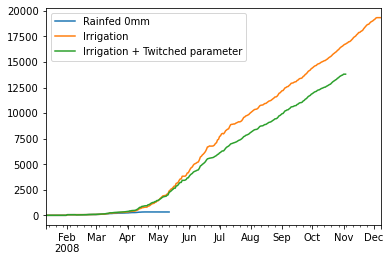

In [19]:
ax = output_1.CWAD.plot(label='Rainfed 0mm')
output_2.CWAD.plot(label='Irrigation', ax=ax)
output_3.CWAD.plot(label='Irrigation + Twitched parameter', ax=ax)
ax.legend()

Finally, we can close the simulation environment by calling `DSSAT.close()`. This will remove all the files and folders created to run the model.

In [20]:
dssat.close()

/tmp/dssatsonexzob and its content has been removed.
